In [1]:
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from PIL import Image

from sklearn.model_selection import train_test_split

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [2]:
import gdown

file_id = "19ZAR_TRxY7GuVyLtXlxERmmnG9_FZc2M"
destination = "downloaded_file"

gdrive_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(gdrive_url, destination, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=19ZAR_TRxY7GuVyLtXlxERmmnG9_FZc2M
From (redirected): https://drive.google.com/uc?id=19ZAR_TRxY7GuVyLtXlxERmmnG9_FZc2M&confirm=t&uuid=2b800a69-4f3a-40f6-a746-b7e123c24f5c
To: /content/downloaded_file
100%|██████████| 203M/203M [00:04<00:00, 41.1MB/s]


'downloaded_file'

In [3]:
!unzip downloaded_file

Archive:  downloaded_file
  inflating: fer2013.csv             
  inflating: fer2013/fer2013.csv     


In [4]:

@dataclass
class Config:
    # Dataset parameters
    data_path: str = 'fer2013.csv'
    noise_sigma: float = 25.0
    image_size: Tuple[int, int] = (48, 48)

    # Training parameters
    batch_size: int = 64
    num_workers: int = 4
    num_epochs: int = 20
    learning_rate: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    lambda_L1: float = 100.0

    # Model parameters
    generator_channels: int = 1
    generator_base_filters: int = 16
    discriminator_in_channels: int = 2
    discriminator_features: List[int] = (16, 32, 64, 128)

    # Logging and Checkpointing
    log_dir: str = 'logs'
    checkpoint_dir: str = 'models'
    sample_interval: int = 10  # Save samples every 10 epochs

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'



In [5]:
class DenoiseDataset(Dataset):
    def __init__(self, df: pd.DataFrame, noise_sigma: float, train: bool = True):
        self.df = df
        self.noise_sigma = noise_sigma
        self.train = train

        if self.train:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
            ])
        else:
            self.transform = None

    def _add_gaussian_noise(self, clean_patch: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        noise = np.random.randn(*clean_patch.shape) * self.noise_sigma
        noisy_patch = np.clip(clean_patch + noise, 0, 255).astype(np.uint8)
        return noisy_patch, clean_patch

    def _get_image(self, index: int) -> np.ndarray:
        pixels = self.df.loc[index, 'pixels']
        image = np.array(list(map(int, pixels.split()))).reshape(*Config.image_size).astype(np.uint8)
        return image

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = self._get_image(idx)

        if self.train and self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
            img = np.array(img)

        noisy, clean = self._add_gaussian_noise(img)

        clean = torch.from_numpy(clean).float() / 255.0
        noisy = torch.from_numpy(noisy).float() / 255.0

        clean = clean.unsqueeze(0)  
        noisy = noisy.unsqueeze(0)

        return noisy, clean



In [6]:

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(DownsampleBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.PReLU(out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, cat_channels: int, out_channels: int):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.PReLU(in_channels)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels + cat_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(out_channels)
        )

    def forward(self, x: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        upsample, concat = x
        upsample = self.upsample(upsample)
        x = torch.cat([concat, upsample], dim=1)
        return self.conv(x)


class InputBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(InputBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class OutputBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(OutputBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.PReLU(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class DenoisingBlock(nn.Module):
    def __init__(self, in_channels: int, inner_channels: int, out_channels: int):
        super(DenoisingBlock, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1),
            nn.PReLU(inner_channels),
            nn.Conv2d(in_channels + inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.PReLU(inner_channels),
            nn.Conv2d(in_channels + inner_channels, inner_channels, kernel_size=3, padding=1), 
            nn.PReLU(inner_channels),
            nn.Conv2d(in_channels + inner_channels, out_channels, kernel_size=3, padding=1),  
            nn.PReLU(out_channels)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv_layers[0](x)
        out = self.conv_layers[1](out)

        out = torch.cat([x, out], dim=1)
        out = self.conv_layers[2](out)
        out = self.conv_layers[3](out)

        out = torch.cat([x, out], dim=1)
        out = self.conv_layers[4](out)  
        out = self.conv_layers[5](out)

        out = torch.cat([x, out], dim=1)
        out = self.conv_layers[6](out)  
        out = self.conv_layers[7](out)

        return out + x  


class RDUNet(nn.Module):
    """
    Residual-Dense U-net for image denoising.
    """
    def __init__(self, channels: int = 1, base_filters: int = 64):
        super(RDUNet, self).__init__()
        filters = base_filters

        # Encoder
        self.input_block = InputBlock(channels, filters)
        self.block_0_0 = DenoisingBlock(filters, filters // 2, filters)
        self.block_0_1 = DenoisingBlock(filters, filters // 2, filters)
        self.down_0 = DownsampleBlock(filters, filters * 2)

        self.block_1_0 = DenoisingBlock(filters * 2, filters, filters * 2)
        self.block_1_1 = DenoisingBlock(filters * 2, filters, filters * 2)
        self.down_1 = DownsampleBlock(filters * 2, filters * 4)

        self.block_2_0 = DenoisingBlock(filters * 4, filters * 2, filters * 4)
        self.block_2_1 = DenoisingBlock(filters * 4, filters * 2, filters * 4)
        self.down_2 = DownsampleBlock(filters * 4, filters * 8)

        # Bottleneck
        self.block_3_0 = DenoisingBlock(filters * 8, filters * 4, filters * 8)
        self.block_3_1 = DenoisingBlock(filters * 8, filters * 4, filters * 8)

        # Decoder
        self.up_2 = UpsampleBlock(filters * 8, filters * 4, filters * 4)
        self.block_2_2 = DenoisingBlock(filters * 4, filters * 2, filters * 4)
        self.block_2_3 = DenoisingBlock(filters * 4, filters * 2, filters * 4)

        self.up_1 = UpsampleBlock(filters * 4, filters * 2, filters * 2)
        self.block_1_2 = DenoisingBlock(filters * 2, filters, filters * 2)
        self.block_1_3 = DenoisingBlock(filters * 2, filters, filters * 2)

        self.up_0 = UpsampleBlock(filters * 2, filters, filters)
        self.block_0_2 = DenoisingBlock(filters, filters // 2, filters)
        self.block_0_3 = DenoisingBlock(filters, filters // 2, filters)

        self.output_block = OutputBlock(filters, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        out_0 = self.input_block(x)
        out_0 = self.block_0_0(out_0)
        out_0 = self.block_0_1(out_0)

        out_1 = self.down_0(out_0)
        out_1 = self.block_1_0(out_1)
        out_1 = self.block_1_1(out_1)

        out_2 = self.down_1(out_1)
        out_2 = self.block_2_0(out_2)
        out_2 = self.block_2_1(out_2)

        # Bottleneck
        out_3 = self.down_2(out_2)
        out_3 = self.block_3_0(out_3)
        out_3 = self.block_3_1(out_3)

        # Decoder
        out_4 = self.up_2((out_3, out_2))
        out_4 = self.block_2_2(out_4)
        out_4 = self.block_2_3(out_4)

        out_5 = self.up_1((out_4, out_1))
        out_5 = self.block_1_2(out_5)
        out_5 = self.block_1_3(out_5)

        out_6 = self.up_0((out_5, out_0))
        out_6 = self.block_0_2(out_6)
        out_6 = self.block_0_3(out_6)

        return self.output_block(out_6) + x 


class PatchDiscriminator(nn.Module):
    """
    PatchGAN Discriminator.
    """
    def __init__(self, in_channels: int = 2, features: List[int] = [64, 128, 256, 512]):
        super(PatchDiscriminator, self).__init__()
        layers = []

        # Initial layer
        layers.append(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1)
        )
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # Hidden layers
        in_feat = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Conv2d(in_feat, feature, kernel_size=4, stride=2, padding=1, bias=False)
            )
            layers.append(nn.BatchNorm2d(feature))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_feat = feature

        # Final layer
        layers.append(
            nn.Conv2d(in_feat, 1, kernel_size=4, stride=1, padding=1)
        )

        self.model = nn.Sequential(*layers)

    def forward(self, noisy: torch.Tensor, denoised: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the discriminator.
        Concatenates the noisy input and denoised/generated image.

        Args:
            noisy (torch.Tensor): Noisy input image tensor.
            denoised (torch.Tensor): Denoised/generated image tensor.

        Returns:
            torch.Tensor: Patch-wise authenticity scores.
        """
        x = torch.cat([noisy, denoised], dim=1) 
        return self.model(x)



In [7]:
def init_weights(m: nn.Module):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def evaluate_model(generator: nn.Module, dataloader: DataLoader, device: torch.device) -> Tuple[float, float]:
    generator.eval()
    psnr_total = 0.0
    ssim_total = 0.0
    num_images = 0

    with torch.no_grad():
        for noisy, clean in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)

            denoised = generator(noisy)

            denoised = denoised.cpu().numpy()
            clean = clean.cpu().numpy()

            for i in range(denoised.shape[0]):
                denoised_img = denoised[i, 0]
                clean_img = clean[i, 0]

                psnr_val = psnr(clean_img, denoised_img, data_range=1.0)
                ssim_val = ssim(clean_img, denoised_img, data_range=1.0)

                psnr_total += psnr_val
                ssim_total += ssim_val
                num_images += 1

    avg_psnr = psnr_total / num_images
    avg_ssim = ssim_total / num_images

    print(f'Average PSNR: {avg_psnr:.2f} dB')
    print(f'Average SSIM: {avg_ssim:.4f}')

    return avg_psnr, avg_ssim


def visualize_denoising(generator: nn.Module, dataloader: DataLoader, device: torch.device, config: Config, num_images: int = 5, save: bool = False, epoch: int = None):
    generator.eval()
    with torch.no_grad():
        for noisy, clean in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            denoised = generator(noisy)

            noisy = noisy.cpu().numpy()
            denoised = denoised.cpu().numpy()
            clean = clean.cpu().numpy()

            fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
            for i in range(num_images):
                axes[i, 0].imshow(noisy[i, 0], cmap='gray')
                axes[i, 0].set_title('Noisy')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(denoised[i, 0], cmap='gray')
                axes[i, 1].set_title('Denoised')
                axes[i, 1].axis('off')

                axes[i, 2].imshow(clean[i, 0], cmap='gray')
                axes[i, 2].set_title('Clean')
                axes[i, 2].axis('off')
            plt.tight_layout()

            if save and epoch is not None:
                sample_path = os.path.join(config.checkpoint_dir, f'sample_epoch_{epoch}.png')
                plt.savefig(sample_path)
                print(f'Saved sample visualization to {sample_path}')
            else:
                plt.show()
            plt.close()
            break  



In [8]:

def train(config: Config):
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)

    writer = SummaryWriter(config.log_dir)

    df = pd.read_csv(config.data_path)
    df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

    train_dataset = DenoiseDataset(df=df_train.reset_index(drop=True), noise_sigma=config.noise_sigma, train=True)
    val_dataset = DenoiseDataset(df=df_val.reset_index(drop=True), noise_sigma=config.noise_sigma, train=False)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                              num_workers=config.num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False,
                            num_workers=config.num_workers, pin_memory=True)

    generator = RDUNet(channels=config.generator_channels, base_filters=config.generator_base_filters)
    discriminator = PatchDiscriminator(in_channels=config.discriminator_in_channels, features=config.discriminator_features)

    generator.apply(init_weights)
    discriminator.apply(init_weights)

    device = torch.device(config.device)
    generator.to(device)
    discriminator.to(device)

    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()

    optimizer_G = optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.beta1, config.beta2))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.beta1, config.beta2))

    for epoch in range(1, config.num_epochs + 1):
        generator.train()
        discriminator.train()

        for batch_idx, (noisy, clean) in enumerate(train_loader, 1):
            noisy = noisy.to(device)
            clean = clean.to(device)


            optimizer_D.zero_grad()

            # Generate denoised images
            denoised = generator(noisy)

            pred_real = discriminator(noisy, clean)
            real_labels = torch.ones_like(pred_real, device=device)
            loss_D_real = criterion_GAN(pred_real, real_labels)

            pred_fake = discriminator(noisy, denoised.detach())
            fake_labels = torch.zeros_like(pred_fake, device=device)
            loss_D_fake = criterion_GAN(pred_fake, fake_labels)

            loss_D = (loss_D_real + loss_D_fake) * 0.5

            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            denoised = generator(noisy)

            pred_fake = discriminator(noisy, denoised)
            real_labels_gen = torch.ones_like(pred_fake, device=device)  
            loss_G_GAN = criterion_GAN(pred_fake, real_labels_gen)

            loss_G_L1 = criterion_L1(denoised, clean)

            loss_G = loss_G_GAN + config.lambda_L1 * loss_G_L1

            loss_G.backward()
            optimizer_G.step()

            # Logging
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{config.num_epochs}] Batch {batch_idx}/{len(train_loader)} | "
                      f"Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f} | "
                      f"Loss G_GAN: {loss_G_GAN.item():.4f} | Loss G_L1: {loss_G_L1.item():.4f}")

                # Log to TensorBoard
                global_step = (epoch - 1) * len(train_loader) + batch_idx
                writer.add_scalar('Loss/Discriminator', loss_D.item(), global_step)
                writer.add_scalar('Loss/Generator', loss_G.item(), global_step)
                writer.add_scalar('Loss/Generator_GAN', loss_G_GAN.item(), global_step)
                writer.add_scalar('Loss/Generator_L1', loss_G_L1.item(), global_step)


        generator.eval()
        discriminator.eval()

        with torch.no_grad():
            val_loss_G = 0.0
            val_loss_G_GAN = 0.0
            val_loss_G_L1 = 0.0
            num_val_batches = 0

            for noisy, clean in val_loader:
                noisy = noisy.to(device)
                clean = clean.to(device)

                denoised = generator(noisy)

                # Adversarial loss
                pred_fake = discriminator(noisy, denoised)
                real_labels_val = torch.ones_like(pred_fake, device=device)
                loss_G_GAN = criterion_GAN(pred_fake, real_labels_val)

                # L1 loss
                loss_G_L1 = criterion_L1(denoised, clean)

                # Total generator loss
                loss_G = loss_G_GAN + config.lambda_L1 * loss_G_L1

                val_loss_G += loss_G.item()
                val_loss_G_GAN += loss_G_GAN.item()
                val_loss_G_L1 += loss_G_L1.item()
                num_val_batches += 1

            avg_val_loss_G = val_loss_G / num_val_batches
            avg_val_loss_G_GAN = val_loss_G_GAN / num_val_batches
            avg_val_loss_G_L1 = val_loss_G_L1 / num_val_batches

            print(f"==> Validation Epoch [{epoch}/{config.num_epochs}] | "
                  f"Avg Loss G: {avg_val_loss_G:.4f} | "
                  f"Avg Loss G_GAN: {avg_val_loss_G_GAN:.4f} | "
                  f"Avg Loss G_L1: {avg_val_loss_G_L1:.4f}")

            # Log to TensorBoard
            writer.add_scalar('Val/Loss_G', avg_val_loss_G, epoch)
            writer.add_scalar('Val/Loss_G_GAN', avg_val_loss_G_GAN, epoch)
            writer.add_scalar('Val/Loss_G_L1', avg_val_loss_G_L1, epoch)

            # Save checkpoint
            checkpoint_path = os.path.join(config.checkpoint_dir, f'gan_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

            # Save sample images
            if epoch % config.sample_interval == 0:
                visualize_denoising(generator, val_loader, device, config, num_images=5, save=True, epoch=epoch)

    writer.close()



In [9]:
config = Config()
train(config)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20] Batch 100/505 | Loss D: 0.6926 | Loss G: 5.6037 | Loss G_GAN: 0.6964 | Loss G_L1: 0.0491
Epoch [1/20] Batch 200/505 | Loss D: 0.6887 | Loss G: 5.3744 | Loss G_GAN: 0.7368 | Loss G_L1: 0.0464
Epoch [1/20] Batch 300/505 | Loss D: 0.6218 | Loss G: 5.4015 | Loss G_GAN: 0.9562 | Loss G_L1: 0.0445
Epoch [1/20] Batch 400/505 | Loss D: 0.5224 | Loss G: 5.2012 | Loss G_GAN: 0.7773 | Loss G_L1: 0.0442
Epoch [1/20] Batch 500/505 | Loss D: 0.6375 | Loss G: 5.2199 | Loss G_GAN: 0.7809 | Loss G_L1: 0.0444
==> Validation Epoch [1/20] | Avg Loss G: 5.1290 | Avg Loss G_GAN: 0.8411 | Avg Loss G_L1: 0.0429
Saved checkpoint: models/gan_epoch_1.pth
Epoch [2/20] Batch 100/505 | Loss D: 0.6518 | Loss G: 4.6383 | Loss G_GAN: 0.6926 | Loss G_L1: 0.0395
Epoch [2/20] Batch 200/505 | Loss D: 0.6938 | Loss G: 5.0047 | Loss G_GAN: 0.7191 | Loss G_L1: 0.0429
Epoch [2/20] Batch 300/505 | Loss D: 0.5921 | Loss G: 4.8559 | Loss G_GAN: 0.8685 | Loss G_L1: 0.0399
Epoch [2/20] Batch 400/505 | Loss D: 0.7255 |

<ipython-input-24-eb77392a7270>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/gan_epoch_20.pth')
/usr/local/lib/python3.10/dist-packages/t

Average PSNR: 26.37 dB
Average SSIM: 0.8643


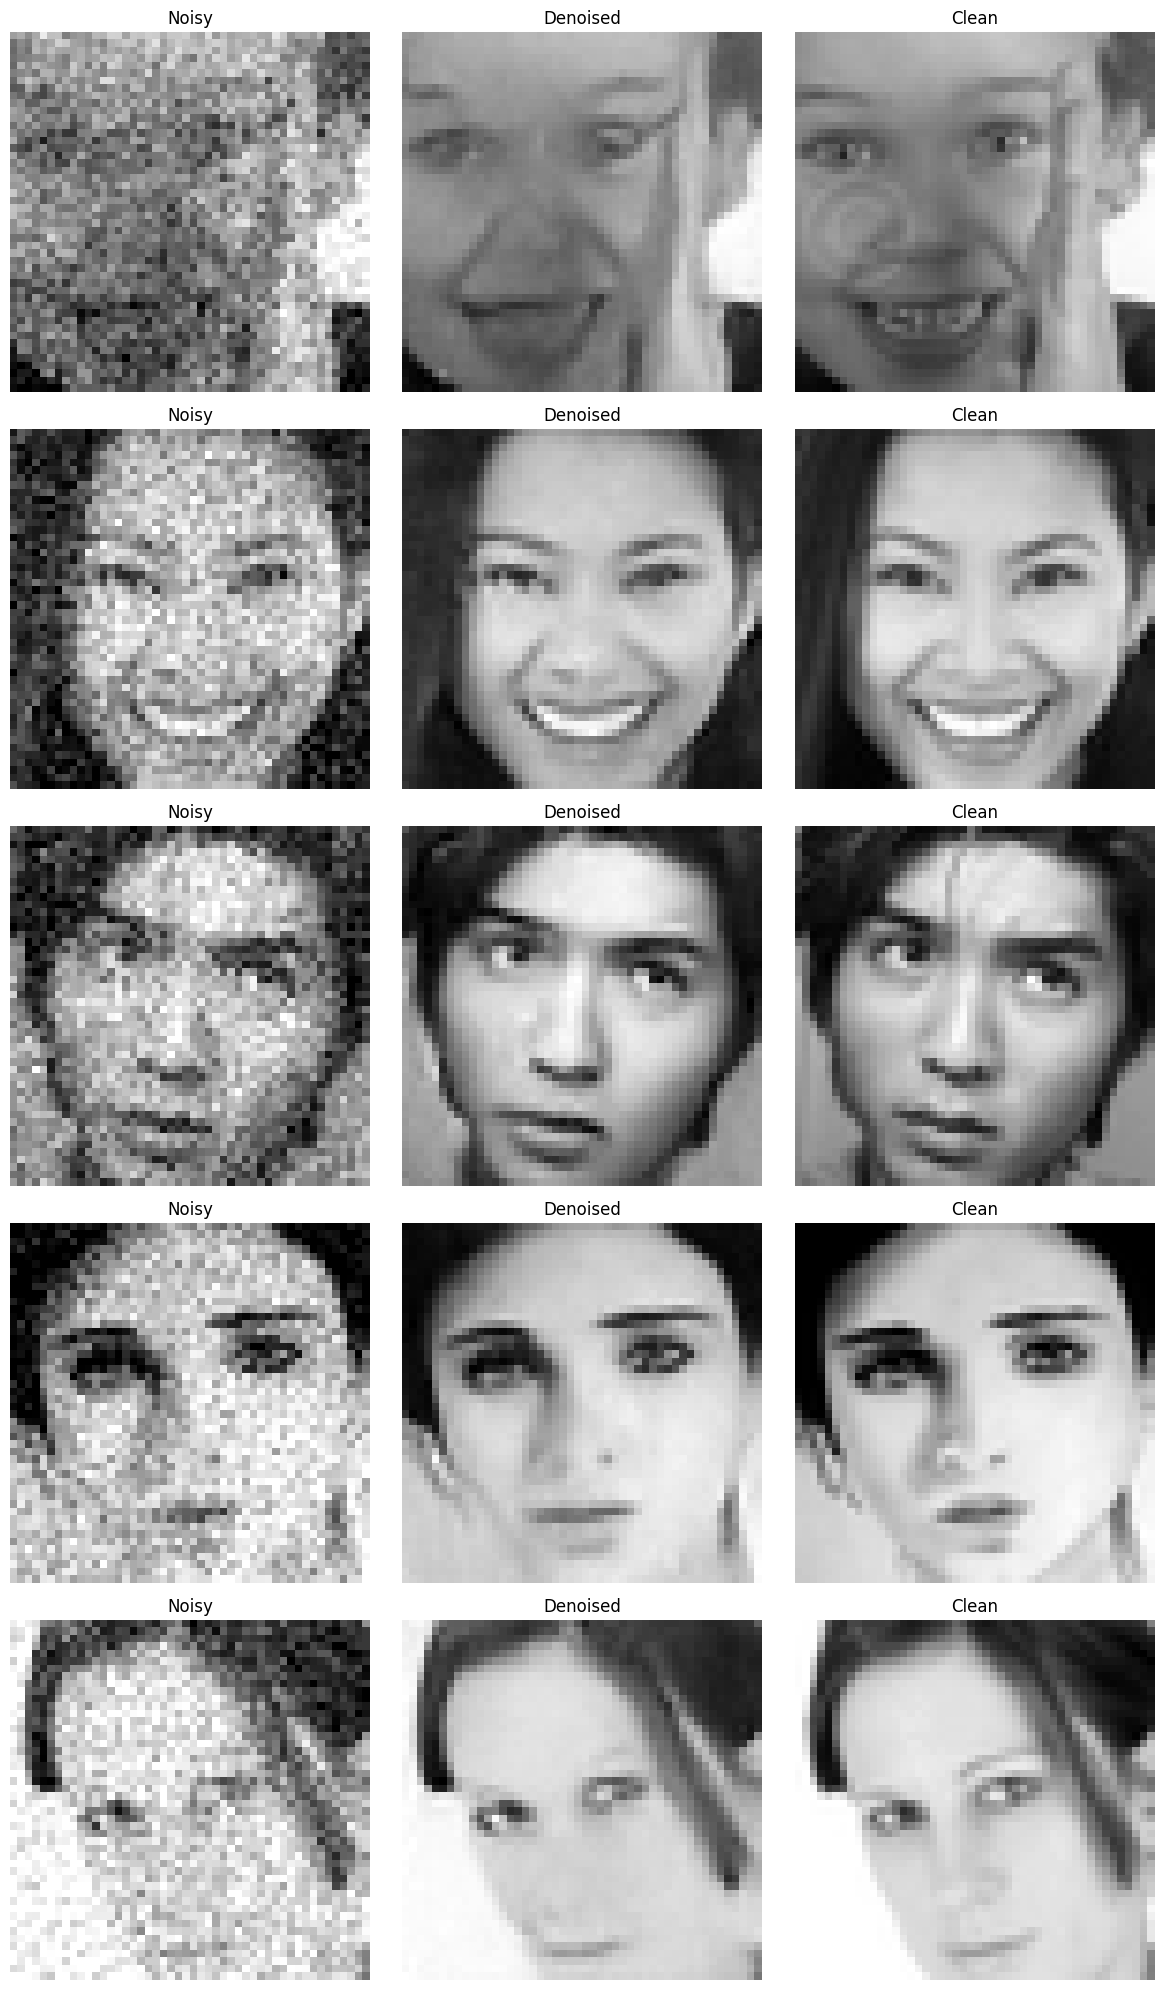

In [24]:
checkpoint = torch.load('models/gan_epoch_20.pth')
generator = RDUNet(channels=config.generator_channels, base_filters=config.generator_base_filters)

generator.load_state_dict(checkpoint['generator_state_dict'])
df = pd.read_csv(config.data_path)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)
val_dataset = DenoiseDataset(df=df_val.reset_index(drop=True), noise_sigma=config.noise_sigma, train=False)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False,
                            num_workers=config.num_workers, pin_memory=True)

device='cpu'
evaluate_model(generator, val_loader, device)
visualize_denoising(generator, val_loader, device, config)